In [42]:
%pip install minatar 

Note: you may need to restart the kernel to use updated packages.


In [43]:
import gymnasium as gym
import minatar.gym  # this registers the MinAtar envs with gymnasium
import random
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from minatar import Environment

# some versions require explicit register call:
minatar.gym.register_envs()

env = gym.make("MinAtar/Breakout-v1")
obs, info = env.reset()
print("OK, made env. obs shape:", obs.shape)

OK, made env. obs shape: (10, 10, 4)


# 3 a)

In [44]:
env = gym.make("MinAtar/Breakout-v1")
#env = Environment('breakout')

obs, info = env.reset()

In [45]:
# print("Observation space:", env.observation_space)
# print("Action space:", env.action_space)

# print("\nObservation shape:", obs.shape)
# print("Number of actions:", env.action_space.n)
# print("Example of what values are in observation:", obs[1][5][:])

The Observation Matrix is a 10x10 grid. For each gridsquare there exists a list with 4 boolean values, indicating weather the square is a "paddle", a "ball-a" a ball-b" or a "brick". The very top left square is at position (0,0). By the observation in square (1,5) above we can see that initally the observation in row 1 col 5 is a brick. This is consistent with the visualizations below. 

### Frame by Frame Visualization of Random Walk

In [46]:
frames = []

terminated = False
truncated = False
step = 0

while step < 6:
    frames.append(obs)
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    step += 1

env.close()

0

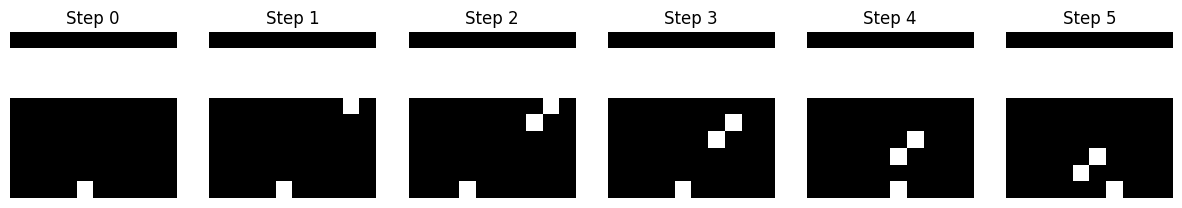

In [47]:
fig, axes = plt.subplots(1, len(frames), figsize=(15,3))

for i, frame in enumerate(frames):
    img = np.max(frame, axis=2)
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"Step {i}")
    axes[i].axis("off")

plt.show()

### Moving Visualization of Random Walk 
(Run again to see the moving visualization)

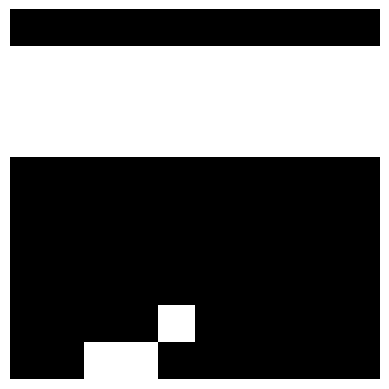

Return: 0


In [48]:

env = Environment("breakout")

terminated = False
G = 0

while not terminated:
    action = random.randrange(env.num_actions())
    reward, terminated = env.act(action)
    G += reward

    # Get state (10x10x4 binary tensor)
    state = env.state()

    # Convert multi-channel binary state to single grayscale image
    img = np.max(state, axis=2)

    clear_output(wait=True)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

    time.sleep(0.2)  #slow down

print("Return:", G)

These visualizations show that random paddle action is not sufficient to maximize rewards. The following sections will investigate if DQL with and without replay are RL methods well suited to learn the strategy behind this game. 

In [49]:
from Learning.Deep_Q_Learning import *


GAMMA = 0.99
EPS = 0.05

LR_list = [1e-4, 5e-4, 1e-3]
batch_style_list = ['sequential', 'uniform_batch', 'priority_batch']
num_seeds = 5
big_train_rewards_list = []  # Outer list over methods; each is list of reward-lists (one per seed)

for batch_style in batch_style_list:
    methods_rewards = []
    for LR in LR_list:
        seed_rewards = []
        for seed in range(num_seeds):
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)
            env = Environment('breakout')
            #env = gym.make("MinAtar/Breakout-v1")
            env.seed(seed)
            agent = Agent(env, EPS, LR, GAMMA, batch_style)
            agent.play()
            seed_rewards.append(agent.rewards_list)
            print("seed" , seed , "LR" , LR , "batch_style" , batch_style) 
        methods_rewards.append(seed_rewards)
    big_train_rewards_list.append(methods_rewards)


seed 0 LR 0.0001 batch_style sequential
seed 1 LR 0.0001 batch_style sequential
seed 2 LR 0.0001 batch_style sequential
seed 3 LR 0.0001 batch_style sequential
seed 4 LR 0.0001 batch_style sequential
seed 0 LR 0.0005 batch_style sequential
seed 1 LR 0.0005 batch_style sequential
seed 2 LR 0.0005 batch_style sequential
seed 3 LR 0.0005 batch_style sequential
seed 4 LR 0.0005 batch_style sequential
seed 0 LR 0.001 batch_style sequential
seed 1 LR 0.001 batch_style sequential
seed 2 LR 0.001 batch_style sequential
seed 3 LR 0.001 batch_style sequential
seed 4 LR 0.001 batch_style sequential
seed 0 LR 0.0001 batch_style uniform_batch
seed 1 LR 0.0001 batch_style uniform_batch
seed 2 LR 0.0001 batch_style uniform_batch
seed 3 LR 0.0001 batch_style uniform_batch
seed 4 LR 0.0001 batch_style uniform_batch
seed 0 LR 0.0005 batch_style uniform_batch
seed 1 LR 0.0005 batch_style uniform_batch
seed 2 LR 0.0005 batch_style uniform_batch
seed 3 LR 0.0005 batch_style uniform_batch
seed 4 LR 0.0005 b

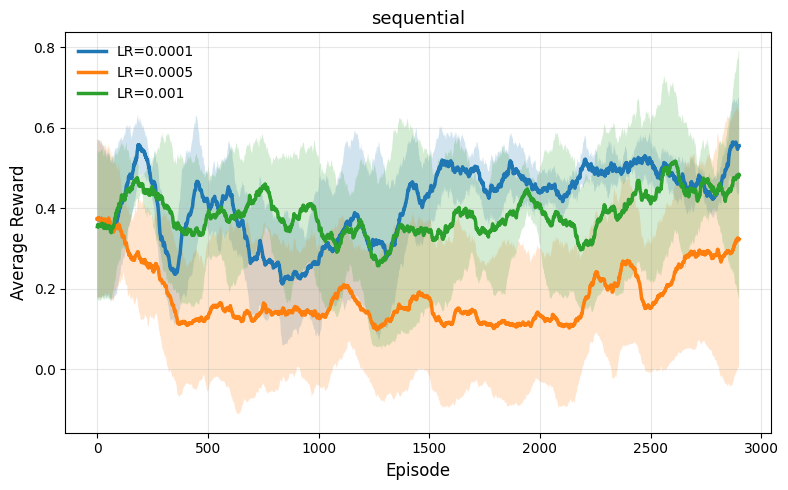

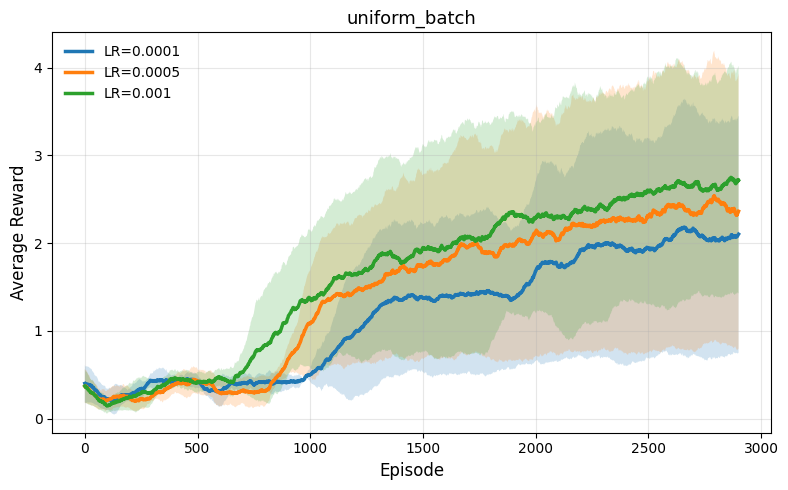

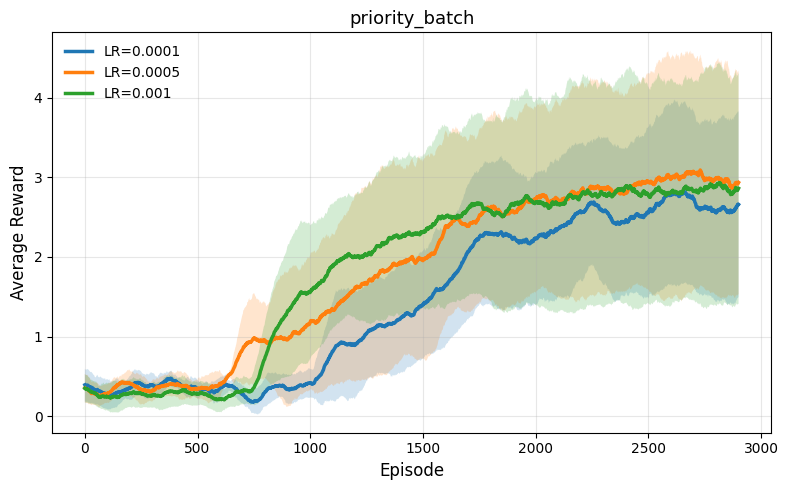

In [50]:
from Learning.plotting import *

lr_labels = [f"LR={lr}" for lr in LR_list]

for b_idx, batch_style in enumerate(batch_style_list):
    plot_compare_smoothed_rewards(
        big_train_rewards_list[b_idx],
        labels=lr_labels,
        window=100,
        title=f"{batch_style}",
    )

Base REINFORCE done.
Episode 0 finished with discounted reward 13.99
Episode 50 finished with discounted reward 19.03
Episode 100 finished with discounted reward 19.84
Episode 150 finished with discounted reward 16.55
Episode 200 finished with discounted reward 13.13
Episode 250 finished with discounted reward 12.25
Episode 300 finished with discounted reward 19.03
Episode 350 finished with discounted reward 10.47
Episode 400 finished with discounted reward 14.85
Episode 450 finished with discounted reward 10.47
Episode 500 finished with discounted reward 13.99
Episode 550 finished with discounted reward 23.77
Episode 600 finished with discounted reward 44.73
Episode 650 finished with discounted reward 38.89
Episode 700 finished with discounted reward 55.25
Episode 750 finished with discounted reward 27.50
Episode 800 finished with discounted reward 33.77
Episode 850 finished with discounted reward 30.36
Episode 900 finished with discounted reward 68.20
Episode 950 finished with discou

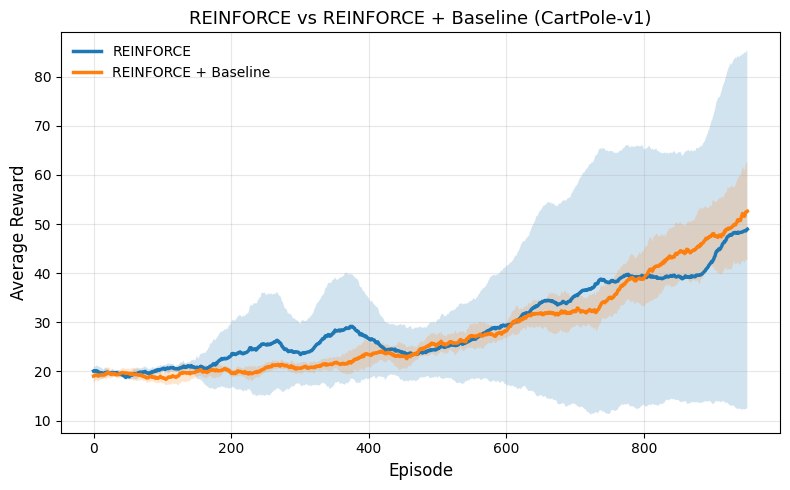

In [51]:
from Learning.policy_gradient import *
from Learning.plotting import *
import numpy as np
import random
import torch
import gymnasium as gym


num_seeds = 5

# ---------------- Part (a): REINFORCE vs REINFORCE + Baseline ----------------
base_seed_rewards = []
baseline_seed_rewards = []

for seed in range(num_seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    env = gym.make("CartPole-v1")
    #env = Environment('cartpole')
    try:
        env.reset(seed=seed)
        env.action_space.seed(seed)
    except TypeError:
        pass

    agent = REINFORCE_Agent(env, EPS)
    agent.play()
    base_seed_rewards.append(list(agent.discounted_reward_list))
    env.close()

print("Base REINFORCE done.")

for seed in range(num_seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    env = gym.make("CartPole-v1")
    try:
        env.reset(seed=seed)
        env.action_space.seed(seed)
    except TypeError:
        pass

    agent = REINFORCE_Agent_with_Baseline(env, EPS)
    agent.play()
    baseline_seed_rewards.append(list(agent.discounted_reward_list))
    env.close()

print("REINFORCE + Baseline done.")

plot_compare_smoothed_rewards(
    [base_seed_rewards, baseline_seed_rewards],
    labels=["REINFORCE", "REINFORCE + Baseline"],
    window=50,
    title="REINFORCE vs REINFORCE + Baseline (CartPole-v1)",
)

Temperature sweep done.


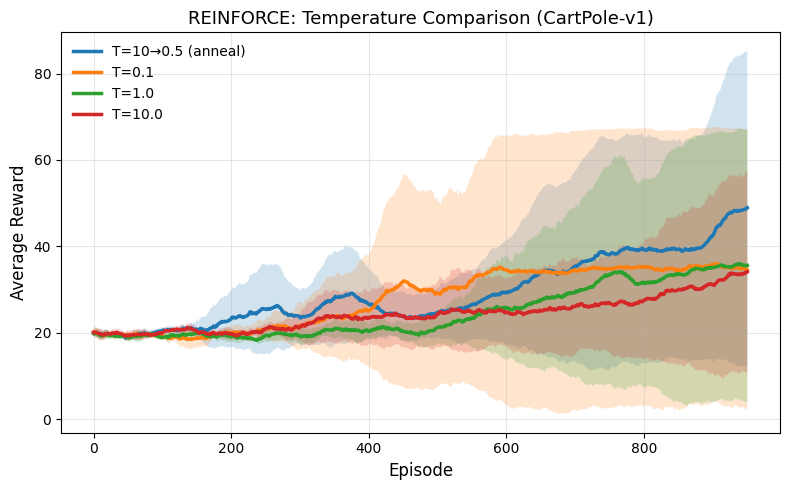

In [52]:
# ---------------- Part (b): REINFORCE temperature comparison ----------------
temp_configs = [
    (10.0, True,  "T=10→0.5 (anneal)"),
    (0.1,  False, "T=0.1"),
    (1.0,  False, "T=1.0"),
    (10.0, False, "T=10.0"),
]

methods_rewards = []

for T, do_anneal, label in temp_configs:
    seed_rewards = []
    for seed in range(num_seeds):
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        env = gym.make("CartPole-v1")
        try:
            env.reset(seed=seed)
            env.action_space.seed(seed)
        except TypeError:
            pass

        agent = REINFORCE_Agent(env, EPS, temperature=T, anneal=do_anneal)
        agent.play()
        seed_rewards.append(list(agent.discounted_reward_list))
        env.close()

    methods_rewards.append(seed_rewards)

print("Temperature sweep done.")

plot_compare_smoothed_rewards(
    methods_rewards,
    labels=[label for _, _, label in temp_configs],
    window=50,
    title="REINFORCE: Temperature Comparison (CartPole-v1)",
)

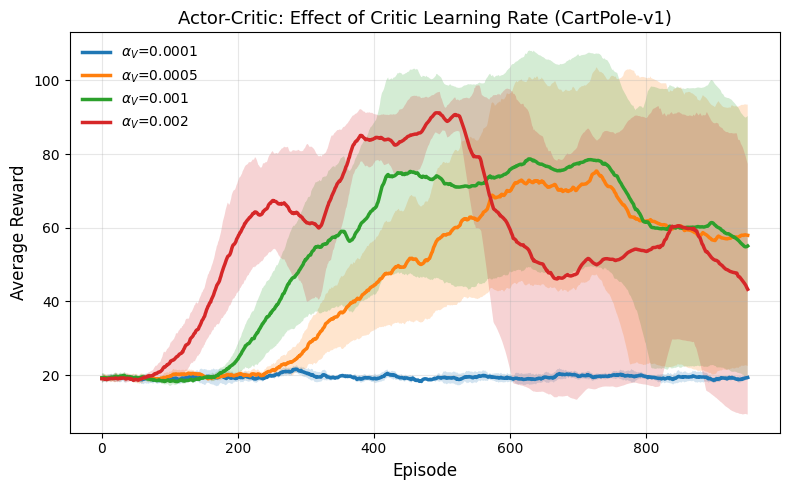

In [54]:
from Learning.actor_critic import *
from Learning.plotting import *

import numpy as np
import random
import torch
import gymnasium as gym

num_seeds = 5

lr_value_list = [1e-4, 5e-4, 1e-3, 2e-3]
methods_rewards = []

for lr_v in lr_value_list:
    seed_rewards = []
    for seed in range(num_seeds):
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        env = gym.make("CartPole-v1")
        try:
            env.reset(seed=seed)
            env.action_space.seed(seed)
        except TypeError:
            pass

        agent = Actor_Critic_Agent(env, EPS, lr_value=lr_v)
        agent.play()
        seed_rewards.append(list(agent.discounted_reward_list))
        env.close()

    methods_rewards.append(seed_rewards)

plot_compare_smoothed_rewards(
    methods_rewards,
    labels=[f"$\\alpha_V$={lr}" for lr in lr_value_list],
    window=50,
    title="Actor-Critic: Effect of Critic Learning Rate (CartPole-v1)",
)